In [1]:
import io
from itertools import product
import logging; L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import re
import yaml

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
import sys
sys.path.append("../..")
import berp.trainer  # nice yaml dump defaults
from berp.models import load_model
from berp.viz.cluster import cluster_predictor
from berp.viz.trf import plot_trf_coefficients
from berp.viz.trf_em import pipeline_to_dataframe

In [4]:
workflow = "heilbron2022"
lm = "EleutherAI/gpt-neo-2.7B/n10000"
model_paradigm = "cannon_wide"
model_run = "trf-cannon_3quantiles"

montage = "biosemi128"
# If `None`, use all sensors in model fits
sensors = None

## Load model

In [5]:
model_dir = f"../../workflow/{workflow}/results{'_' + model_paradigm if model_paradigm is not None else ''}/{lm}/{model_run}"

In [6]:
pipe = load_model(model_dir, device="cpu")

In [7]:
print(yaml.safe_dump(pipe.get_params()))

confusion: tensor of type torch.float64, shape torch.Size([40, 40])
encoder: "TemporalReceptiveField(alpha=82468.40682196281, fit_intercept=True,\n  \
  \                     name='baf59f60a976403db080a7fc4a154857',\n               \
  \        optim=AdamSolver(n_batches=50,\n                                      \
  \  name='baf59f60a976403db080a7fc4a154857',\n                                  \
  \      random_state=RandomState(MT19937) at 0x2B739EA5AD40),\n                 \
  \      sfreq=128.0, tmax=0.75, tmin=0.0)"
encoder__alpha: 82468.40682196281
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: null
encoder__name: baf59f60a976403db080a7fc4a154857
encoder__optim: "AdamSolver(n_batches=50, name='baf59f60a976403db080a7fc4a154857',\n\
  \           random_state=RandomState(MT19937) at 0x2B739EA5AD40)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 50
encoder__optim__name: baf5

## Prepare MNE metadata

In [8]:
if sensors is None:
    sensors = next(iter(pipe.encoders_.values())).output_names

for enc in pipe.encoders_.values():
    # TODO relax -- could be a subset. if so will need to subset/reorder later
    assert enc.output_names == sensors
    
sensors

['B22', 'D19', 'A19', 'C22', 'C10', 'C32', 'A7', 'B4']

In [9]:
info = mne.create_info(sensors, pipe.encoder.sfreq, "eeg")
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: B22, D19, A19, C22, C10, C32, A7, B4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 128.0 Hz
>

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 8


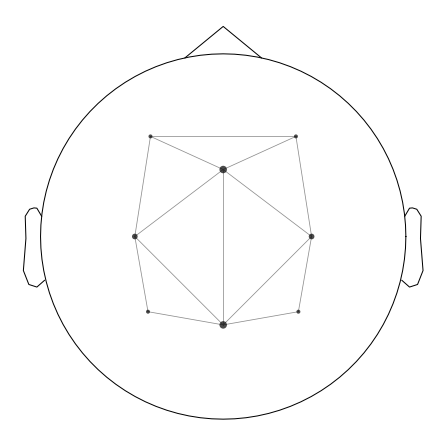

In [10]:
adjacency, ch_names = mne.channels.find_ch_adjacency(info, "eeg")
mne.viz.plot_ch_adjacency(info, adjacency, ch_names)
None

## Clean up model representation

In [11]:
ts_predictor_names, var_predictor_names = pipe.encoder_predictor_names
predictor_names = ts_predictor_names + var_predictor_names

In [18]:
trf_df = pipeline_to_dataframe(pipe)

In [19]:
def get_coef_estimates(trf_df) -> np.ndarray:
    """
    returns n_subjects * n_times * n_channels coefficient representation for
    statistical analysis
    """
    return trf_df.reset_index().set_index(["subject", "epoch_time", "sensor"]).coef.to_numpy() \
        .reshape((len(pipe.encoders_), -1, len(sensors)))

In [20]:
# Sanity check that reading the dataframe is equivalent to reading the raw coefs
t1 = np.stack([
    encoder.coef_[1, :, :]
    for encoder in pipe.encoders_.values()
])
t2 = get_coef_estimates(trf_df[trf_df.predictor_name == predictor_names[1]])
np.testing.assert_almost_equal(t1, t2)

## Test

In [33]:
def prepare_predictor_difference(p1, p2):
    """
    compute difference p2 - p1 coefficients
    """
    df = trf_df.reset_index().set_index(["predictor_name", "subject", "epoch_time", "sensor"])
    df = df.loc[[p1, p2]].coef
    ret = (df.loc[p2] - df.loc[p1]).reset_index()
    ret["predictor_name"] = f"{p2} - {p1}"
    
    return ret

In [24]:
def cluster_predictor_(predictor_df, *args, **kwargs):
    if isinstance(predictor_df, str):
        predictor_df = trf_df[trf_df.predictor_name == predictor_df]
    return cluster_predictor(predictor_df, *args, info=info, **kwargs)

## Plot results

### Main effects

In [ ]:
# cluster_rec_onset0 = cluster_predictor("var_recognition_onset_0", n_jobs=2, plot=False)

Using a threshold of 2.100922
stat_fun(H1): min=-8.975772 max=9.228945
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

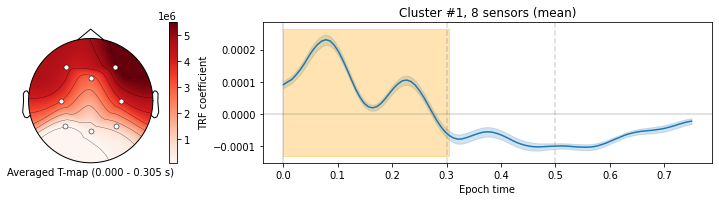

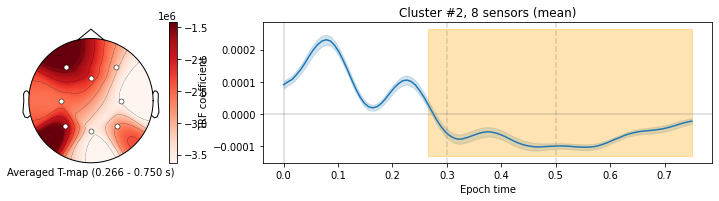

<Figure size 432x288 with 0 Axes>

In [27]:
cluster_predictor_("var_recognition_onset_0", n_jobs=2, threshold=None)
None

Using a threshold of 2.100922
stat_fun(H1): min=-7.530097 max=1.783713
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

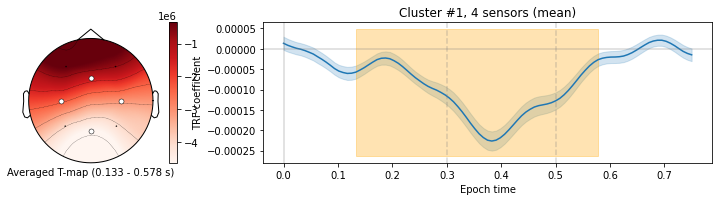

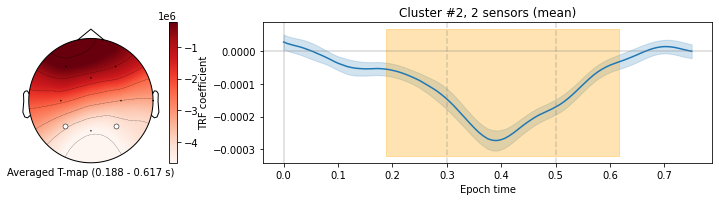

<Figure size 432x288 with 0 Axes>

In [28]:
cluster_word_surprisal0 = cluster_predictor_("var_word_surprisal_0", n_jobs=2)

Using a threshold of 2.100922
stat_fun(H1): min=-8.472322 max=6.684527
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

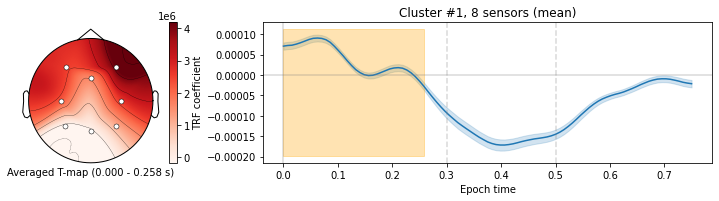

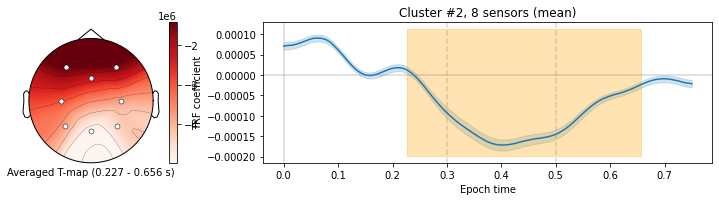

<Figure size 432x288 with 0 Axes>

In [29]:
cluster_word_surprisal1 = cluster_predictor_("var_word_surprisal_1", n_jobs=2)

Using a threshold of 2.100922
stat_fun(H1): min=-3.543077 max=4.464408
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

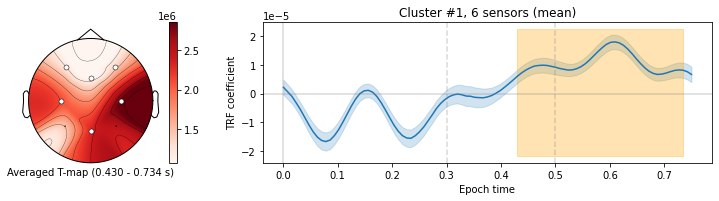

<Figure size 432x288 with 0 Axes>

In [30]:
cluster_word_surprisal2 = cluster_predictor_("var_word_surprisal_2", n_jobs=2)

Using a threshold of 2.100922
stat_fun(H1): min=-6.602186 max=5.973168
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

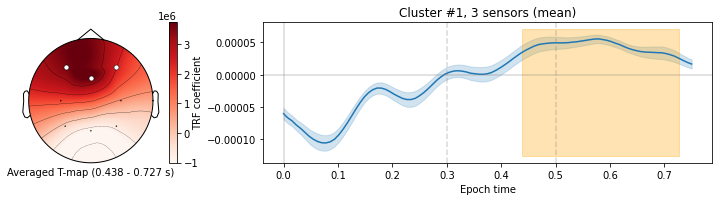

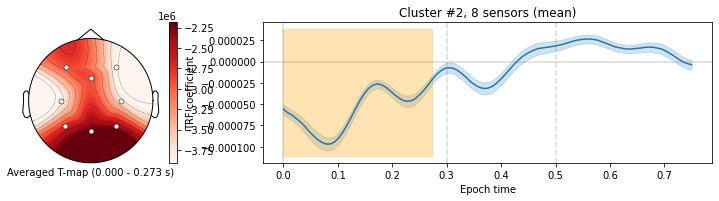

<Figure size 432x288 with 0 Axes>

In [31]:
cluster_word_surprisal3 = cluster_predictor_("var_word_surprisal_3", n_jobs=2)

### Differences

Using a threshold of 2.100922
stat_fun(H1): min=-6.791726 max=8.596844
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

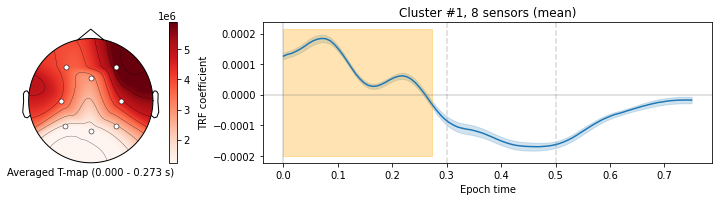

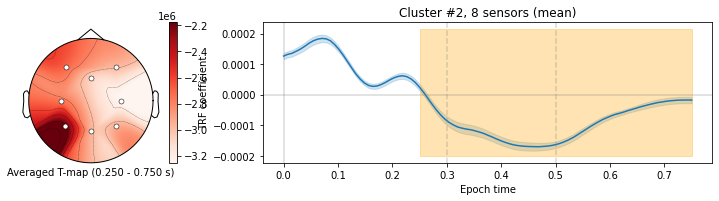

ClusterResult(T_obs=array([[ 5.830646  ,  4.4747295 ,  3.9904523 ,  3.8243883 ,  5.4241977 ,
         4.0037556 ,  3.3221827 ,  5.1590643 ],
       [ 5.947531  ,  4.658788  ,  3.9395225 ,  4.2304454 ,  6.366575  ,
         4.3711386 ,  3.0243034 ,  4.728239  ],
       [ 5.9189487 ,  4.7924237 ,  3.6658208 ,  4.4709005 ,  7.1722517 ,
         4.6153746 ,  2.7924109 ,  4.2146626 ],
       [ 5.872952  ,  4.994218  ,  3.3715065 ,  4.740534  ,  8.034443  ,
         4.9149513 ,  2.626142  ,  3.6599967 ],
       [ 5.8025107 ,  5.2063336 ,  3.1594608 ,  4.9301443 ,  8.431485  ,
         5.1490436 ,  2.5910153 ,  3.2066364 ],
       [ 5.796803  ,  5.433978  ,  3.0645278 ,  5.114192  ,  8.387291  ,
         5.346263  ,  2.67399   ,  2.9289641 ],
       [ 5.919621  ,  5.667405  ,  3.0882113 ,  5.317439  ,  8.15249   ,
         5.508396  ,  2.868861  ,  2.816839  ],
       [ 6.1261573 ,  5.877329  ,  3.1909423 ,  5.5107083 ,  7.873179  ,
         5.638745  ,  3.1417139 ,  2.8422337 ],
       [ 6.4

<Figure size 432x288 with 0 Axes>

In [34]:
cluster_predictor_(
    prepare_predictor_difference("var_word_surprisal_3", "var_word_surprisal_1"),
    n_jobs=2, threshold=None)